### Problem statement and description
- The analysis aims to predict whether a reviewer is more likely to give a movie a good rating (>= 6 stars) or a bad one (<= 5 stars) based on the content of the review
- The project uses imdb dataset available @ ai.standford.edu/~amaas/data/sentiment
- The project looks at:
    - 50,000 reviews 
    - Compare the classification of good (positive) / bad (negative) review using various ML techniques
    - Implement out-of-core learning to reduce run time 

### Project pipeline
- Collect data
- EDA
- Clean text
- Preprocess text (tokenisation / vectorisation)
- Model selection and hyperparameter turning (GridSearch CV & Logistic Regression)
- Improve model run time by using out-of-core learning in combination with online algorithm (Minibatch run + Hashvectorisation + partial_fit)
- Model evaluation

### Import all python packages 

In [ ]:
###### Import missing / required python packages
# import sys
# !{sys.executable} -m pip install pyprind

In [204]:
import pyprind
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import time
from matplotlib import rcParams

#### Packages for words processing
# import nltk
# nltk.download("stopwords")
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
#### Packages for vectoring tokens
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
#### Packages used for processing ML
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
#### Packages used for algorithm
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC 
#### Packages supporting online learning (partial_fit)
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import MultinomialNB

In [4]:
###### Importing data from zip file @ ai.standford.edu/~amaas/data/sentiment
pbar = pyprind.ProgBar(50000)  #### 50000 is the number of documents to be read
label={"pos":1,"neg":0}  ### labeling sentiment of reviews
df = pd.DataFrame()
for s in ("test","train"):
    for l in ("pos","neg"):
        path="./aclImdb/%s/%s" % (s,l)
        for file in os.listdir(path):
            with open(os.path.join(path,file),"r",encoding="utf8") as infile:
                txt = infile.read()
                df = df.append([[txt,label[l]]],ignore_index=True)
                pbar.update()
df.columns =["review","sentiment"]

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:04:25


In [5]:
# ###### Reshuffle all the samples
np.random.seed(0)
df=df.reindex(np.random.permutation(df.index))
df.to_csv("./movie_data.csv",index=False)  
df = pd.read_csv("movie_data.csv")

### Exploratory Data Analysis

In [6]:
df.head(5)

,review,sentiment
0,Some things need to be clarified. The picture ...,0
1,I don't know why the critics trashed this movi...,1
2,This is quite an amazing film to watch. Using ...,1
3,This is one of those films you can have on for...,0
4,I wasn't quite sure if this was just going to ...,1


In [7]:
df.shape

(50000, 2)

In [8]:
df["sentiment"].value_counts()  #### No issues with imbalanced data

0    25000
1    25000
Name: sentiment, dtype: int64

### Cleaning text data
- removing html markers
- turn all into lower case
- emoji clean up

In [9]:
def preprocessor_v1(text):
    text=re.sub('<[^>]*>',"",text)    ##### Replace HTML markups with empty string
    emoticons = re.findall("(?::|;|=)(?:-)?(?:\)|\(|D|P)",text)
    #### Removing all non-word characters, turn into lower case, add the emoticons at the end (- removing the nose (-) character)
    #### Adding emojis at the end not the most elegant approach but for 1-word token or (1 gram), order of words does not matter
    text=re.sub('[\W]+', ' ',text.lower()) +"".join(emoticons).replace("-","")
    return text

In [10]:
##### Check on examples of reviews
example1 = df["review"][10]
example1,clean_ex= example1, preprocessor_v1(example1)

In [11]:
example1

"I thought maybe a film which boasted a cast including Peter O'Toole, Susannah York, Michael Craig & Harry Andrews might be worth watching. Alas, I was wrong. Utter pretentious nonsense from beginning to end with both O'Toole and York overacting wildly. I watched it twice and still have no idea what is was about. I've a feeling O'Toole plays the Laird of a Scottish castle who has a drink problem and likes reliving childhood games with his sister (York). He is also barking mad. But apart from that, your guess is as good as mine.<br /><br />The film has no redeeming feature whatsoever. I can only assume the cast and director were blackmailed into making this dreary, unimaginative, stagy piffle. Clearly a waste of the time of a talented cast and director. Risible."

In [12]:
clean_ex

'i thought maybe a film which boasted a cast including peter o toole susannah york michael craig harry andrews might be worth watching alas i was wrong utter pretentious nonsense from beginning to end with both o toole and york overacting wildly i watched it twice and still have no idea what is was about i ve a feeling o toole plays the laird of a scottish castle who has a drink problem and likes reliving childhood games with his sister york he is also barking mad but apart from that your guess is as good as mine the film has no redeeming feature whatsoever i can only assume the cast and director were blackmailed into making this dreary unimaginative stagy piffle clearly a waste of the time of a talented cast and director risible '

In [13]:
df["review"] = df["review"].apply(preprocessor_v1)

In [14]:
df.head(5)

,review,sentiment
0,some things need to be clarified the picture o...,0
1,i don t know why the critics trashed this movi...,1
2,this is quite an amazing film to watch using d...,1
3,this is one of those films you can have on for...,0
4,i wasn t quite sure if this was just going to ...,1


### Bag of words model in combination with TF-IDF:
1. Tokenization of unique words in the whole text
2. Construct feature vector for each document and count how often each word occurs
3. Assessing relevance of words by downweighting high frequency words using tf-idf

#### 1. Processing documents into tokens:
- Word Tokensizing: split the text corpora into individual elements separated by white space
- Word Stemming: turning words into their root forms allowing us to map related words to each other
    - Methods used here is Porter stemming - simplest stemming method (e.g. working -> work). Other methods are snowball and Lancaster which are faster but also more aggressive
    - Note: word stemming can create unreal words (e.g. thus -> thu)
    - More advanced techniques such as lemmatization aiming to produce grammatically correct (canonical) words, (e.g. better -> good) . Lemmas might not improve performance much more than simple word stemming. Stemming is a lot faster than lemmatizations

In [42]:
#### Split text into words separated by white spaces
def tokenizer(text):
    return text.split()
#### Turning words into their root forms with Porter
porter = PorterStemmer()
def tokenizer_porter(text):
    return[porter.stem(word) for word in text.split()]
#### Using lemmarisation to find true root of word meaning
lemma = WordNetLemmatizer()
def tokenizer_lemma(text):
    return [lemma.lemmatize(word, pos='a') for word in text.split()]  #### POS - part of speech tag cannot not used algorithmically, here try adjective 
#### Turning words into their root forms with Porter

#### 2. Vectorizing tokens (feature vectors transformation):
- Turning tokens into feature vectors
- Counting the number of unique words in the entire text and mapping each word in the document to its indices of the vocabulary vector --- Default is 1-gram but can change to more. For spam filtering its likely to be 3-4 (N-gram)
- The value in the feature vectors are called raw term frequencies tf(t,d) --- the number of times a term t occurs in a document d
- The result of this is a sparse matrix of integers for each review encoding not present (0) / present (# of occurrances) of all stemmed words in the 50k reviews 

#### 3. Assessing relevance of tokens:
- Removing stop-words
- TF-IDF: on top of vectorization, a weight can be applied to tokens in order to downweight those frequently occurs in the text (occurs in other reviews)
- After this the sparse matrix of vectorised tokens is transformed with downweighed term frequencies 
- Note: TF-IDF has taken into account stop-words as these words have already been downweighed in the final feature vector

In [16]:
#### Forming the list of stop words - potentially removed from the analysis words with little meaning
stop = stopwords.words("english")
print("The number of words in stopword list: {:d}".format(len(stop)))
print("Example of stopwords {:s}".format(str(stop[0:10])))

The number of words in stopword list: 179
Example of stopwords ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


## Implementing Logistic Regression 

#### Splitting dataset into train and test sets

In [135]:
x_train,x_test,y_train,y_test = train_test_split(df["review"].values,df["sentiment"].values,test_size=0.5,random_state=100)

#### Applying TF-IDF to vectorize and assess word relevance

In [43]:
### Vectorisation using tf-idf:
### Turning the dataframe of review and label into the dataframe of feature vectors with index based on indexing of vocab and frequency in each doc
tfidf = TfidfVectorizer(strip_accents=None,lowercase=False,preprocessor=None)  

#### Defining ML algorithms to be tested

In [44]:
### Initiate ML algorithm
lr = LogisticRegression(random_state=1)

pipe = Pipeline([("vect",tfidf),("clf",lr)])
##### The following describe 2 algorithms: 1 with normalised tf and the other with raw tf
##### Only consider unigram in this exercise,  both cases when stop_words are removed as well as kept in IF-IDF are considered
param_grid = [{'vect__ngram_range':[(1,1)],"vect__stop_words":[stop,None],"vect__tokenizer":[tokenizer,tokenizer_porter,tokenizer_lemma],
               'vect__use_idf':[True],'vect__smooth_idf':[True],'vect__norm':["l2"],
              "clf__penalty":["l1","l2"],"clf__C":[1.0,10.0,100],"clf__max_iter":[150]}]   ######### Use normalised term frequency
#              {'vect__ngram_range':[(1,1)],"vect__stop_words":[stop,None],"vect__tokenizer":[tokenizer,tokenizer_porter],
#               "vect__use_idf":[False],"vect__norm":[None], ######## Use the raw term frequencies without log and d transformation
#               "clf__penalty":["l1","l2"],"clf__C":[1.0,10.0,100.0]}]

In [45]:
print("All parameters of steps included in the pipeline:")
pipe.get_params()

All parameters of steps included in the pipeline:


{'memory': None,
 'steps': [('vect', TfidfVectorizer(lowercase=False)),
  ('clf', LogisticRegression(random_state=1))],
 'verbose': False,
 'vect': TfidfVectorizer(lowercase=False),
 'clf': LogisticRegression(random_state=1),
 'vect__analyzer': 'word',
 'vect__binary': False,
 'vect__decode_error': 'strict',
 'vect__dtype': numpy.float64,
 'vect__encoding': 'utf-8',
 'vect__input': 'content',
 'vect__lowercase': False,
 'vect__max_df': 1.0,
 'vect__max_features': None,
 'vect__min_df': 1,
 'vect__ngram_range': (1, 1),
 'vect__norm': 'l2',
 'vect__preprocessor': None,
 'vect__smooth_idf': True,
 'vect__stop_words': None,
 'vect__strip_accents': None,
 'vect__sublinear_tf': False,
 'vect__token_pattern': '(?u)\\b\\w\\w+\\b',
 'vect__tokenizer': None,
 'vect__use_idf': True,
 'vect__vocabulary': None,
 'clf__C': 1.0,
 'clf__class_weight': None,
 'clf__dual': False,
 'clf__fit_intercept': True,
 'clf__intercept_scaling': 1,
 'clf__l1_ratio': None,
 'clf__max_iter': 100,
 'clf__multi_class'

#### Using gridsearchCV to find the combination of hyperparameters with highest accuracy:
- Each hyperparameter set is validated using KFold

In [51]:
%%time
kf = KFold(n_splits=3,shuffle=True,random_state=42)
lr_tfidf = GridSearchCV(pipe,param_grid=param_grid,scoring="accuracy",cv=kf,verbose=1,n_jobs=-1)
lr_tfidf.fit(x_train,y_train)
#### Issues with nan might arise due to different feature vectors appear for the training vs validation set

Fitting 3 folds for each of 36 candidates, totalling 108 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
 0.88575988 0.88455984 0.88467988 0.88555985 0.88387979 0.88339985
        nan        nan        nan        nan        nan        nan
 0.88808002 0.88459989 0.88640007 0.89179989 0.88747984 0.89083988
        nan        nan        nan        nan        nan        nan
 0.8825201  0.87307991 0.88048011 0.88507998 0.87727986 0.88467999]
  warnings.warn(


Wall time: 22min 43s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(lowercase=False)),
                                       ('clf',
                                        LogisticRegression(random_state=1))]),
             n_jobs=-1,
             param_grid=[{'clf__C': [1.0, 10.0, 100], 'clf__max_iter': [150],
                          'clf__penalty': ['l1', 'l2'],
                          'vect__ngram_range': [(1, 1)], 'vect__norm': ['l2'],
                          'vect__smooth_idf': [True],
                          'vect__stop_words': [['i', 'me', 'my', 'myself', 'we',...
                                                "you'll", "you'd", 'your',
                                                'yours', 'yourself',
                                                'yourselves', 'he', 'him',
                                                'his', 'himself', 'she',
                                                "she's", 'her', '

In [52]:
print("Hyperparameters of best algorithm:")
lr_tfidf.best_params_

Hyperparameters of best algorithm:


{'clf__C': 10.0,
 'clf__max_iter': 150,
 'clf__penalty': 'l2',
 'vect__ngram_range': (1, 1),
 'vect__norm': 'l2',
 'vect__smooth_idf': True,
 'vect__stop_words': None,
 'vect__tokenizer': <function __main__.tokenizer(text)>,
 'vect__use_idf': True}

In [53]:
print("Best cross validation accuracy score: %.3f" % lr_tfidf.best_score_)

Best cross validation accuracy score: 0.892


#### Select the hyperparameter set giving highest accuracy to evaluate the model on test set

In [54]:
###### Choosing the hyperparameter of best algorithm to test
clf_final = lr_tfidf.best_estimator_
print("Accuracy of the test set: %.3f" %clf_final.score(x_test,y_test))

Accuracy of the test set: 0.900


Conclusion: an accuracy score of 90% was achieved with Logistic Regression where C = 10 and an unigram consideration. In terms of text processing, not removing stop-words and a simple tokenizers without stemming and lemmatisation gave the best result

## Implementing out of core classification - reducing run time esp. useful for big datasets
- Suitable for data that does not fit into main memory
- Make use of online classifiers, i.e. classifiers that support partial_fit method --- incremental fit on a batch of samples
- Make use of HashingVectorizer --- ensure to project each example into the same feature space even if new features (words) may appear in each batch

In [110]:
def tokenizer_updated(text,stop=True,method=None):
    # import nltk
    # nltk.download("stopwords")
    # from nltk.stem.porter import PorterStemmer
    # from nltk.stem import WordNetLemmatizer
    # from nltk.corpus import stopwords
    """Function used to tokenize docs 
    
    Parameters:
    --------------
    method: {None: only split docs into words using white space, "porter": Using porter stemming, "lemma": use lemmarisation}
    stop: {None: no stop word removed, stop_list: list of stop words to be removed}
    
    Returns:
    --------------
    review, label 
    """
    porter = PorterStemmer()
    lemma = WordNetLemmatizer()
    stop_list = stopwords.words("english")
    if stop == False:
        token_1 = [w for w in text.split()]
    else:
        token_1 = [w for w in text.split() if w not in stop_list]
    if method == None:
        return token_1
    elif method == "porter": 
        return [porter.stem(word) for word in token_1]
    elif method == "lemma": 
        return [lemma.lemmatize(word, pos='a') for word in text.split()] #### POS - part of speech tag cannot not used algorithmically, here try adjective 

In [102]:
##### Define a minibatch function which takes a document stream and return a parituclar number of documents specified by size parameter
##### Execution of try and except. When an exception rule is met, return something else
def get_minibatch(all_docs,size):
    docs,y=[],[]
    try:
        for _ in range(size):
            doc = next(all_docs)
            text,label = doc[0],doc[1]
            docs.append(text)
            y.append(label)
#             print(text,label)
    except StopIteration:
            return None, None
    return docs, y

#### Hashing trick

In [131]:
vect = HashingVectorizer(decode_error="ignore",n_features =2**18,preprocessor=None,tokenizer=tokenizer_updated) # # of features large to reduce hash collisions but increase # of coef in LR

#### Define list of partial_fit_classifiers to be tested

In [149]:
partial_fit_classifiers = {
    "SGD": SGDClassifier(loss="log",max_iter=5,random_state=1),
    "Perceptron": Perceptron(),
#     "NB Multinomial": MultinomialNB(alpha=0.01),
    "Passive-Aggressive": PassiveAggressiveClassifier(),
}

#### Train / test split and transformation

In [218]:
#### Need to rerun this cell first if want to rerun the cells below
x_train,x_test,y_train,y_test = train_test_split(df["review"].values,df["sentiment"].values,test_size=0.1,random_state=100)
all_docs = zip(x_train,y_train)

#### Defining stats summary

In [219]:
#### Define a library summarizing the result of each batch from various classifier 
cls_stats = {}
for cls_name in partial_fit_classifiers:
    #### Each classifier is associated with a dictionary of stat metrics to track
    stats = {
        "n_train": 0,      ##### number of training docs
        "n_train_pos": 0,  ##### number of label positive in training docs
        "accuracy": 0.0,   ##### accuracy
        "accuracy_history": [(0, 0)], 
        "t0": time.time(),
        "runtime_history": [(0, 0)],  #### show the number of docs processed per second
        "total_fit_time": 0.0,
    }
    cls_stats[cls_name] = stats

# Test set accuracy stats
test_stats = {"n_test": 0, "n_test_pos": 0}

n_test_documents = x_test.shape[0]
tick = time.time()

x_test_new = vect.transform(x_test)

vectorizing_time = time.time() - tick
test_stats["n_test"] += len(y_test)
test_stats["n_test_pos"] += sum(y_test)
# print("Test set is %d documents (%d positive)" % (len(y_test), sum(y_test)))

def show_progress(cls_name, stats):
    """Report progress information, return a string."""
    duration = time.time() - stats["t0"]
    s = "{:25s} classifier : \t".format(cls_name)
    s += "{n_train:6d} train docs {n_train_pos:6d} positive) ".format(n_train=stats["n_train"],n_train_pos=stats["n_train_pos"])
    s += "{n_test:6d} test docs {n_test_pos:6d} positive) ".format(n_test=test_stats["n_test"],n_test_pos=test_stats["n_test_pos"])
    s += "accuracy: {:.3f} ".format(stats["accuracy"])
    s += "in {:.2f} {:.0f} docs/s)".format(duration, stats["n_train"] / duration)
    ##### Return a string with classifier name and its associated stats
    return s

In [220]:
import pyprind
pbar=pyprind.ProgBar(int(x_train.shape[0]))
classes =np.array([0,1])

batch_size = 5000
total_vect_time = 0.0
num_batches = int(x_train.shape[0]/batch_size)

for i in range(num_batches):
    tick = time.time()  #### time at the start of running the batch
    x_train_mini,y_train_mini = get_minibatch(all_docs,size=batch_size)
    if not x_train_mini:  ##### if x_train_mini is empty
        break
        
    #### Hashvectoring the training dataset
    x_train_mini = vect.transform(x_train_mini)
    total_vect_time += time.time() - tick
    
    #### Partial_fit with different classifiers
    for cls_name, cls in partial_fit_classifiers.items():
        tick = time.time()
        # update estimator with examples in the current mini-batch
        cls.partial_fit(x_train_mini, y_train_mini, classes=classes)

        # accumulate test accuracy stats
        cls_stats[cls_name]["total_fit_time"] += time.time() - tick
        cls_stats[cls_name]["n_train"] += x_train_mini.shape[0]
        cls_stats[cls_name]["n_train_pos"] += sum(y_train_mini)
        tick = time.time()
        cls_stats[cls_name]["accuracy"] = cls.score(x_test_new, y_test)
        cls_stats[cls_name]["prediction_time"] = time.time() - tick  #### time it takes to predict 
        acc_history = (cls_stats[cls_name]["accuracy"], cls_stats[cls_name]["n_train"])
        cls_stats[cls_name]["accuracy_history"].append(acc_history)
        run_history = (
            cls_stats[cls_name]["accuracy"],
            total_vect_time + cls_stats[cls_name]["total_fit_time"],)
        cls_stats[cls_name]["runtime_history"].append(run_history)

        if i % 2 == 0: ##### print result every 5 minibatch runs
            print(show_progress(cls_name, cls_stats[cls_name]))
    if i % 2 == 0:
        print("\n")
    pbar.update()

SGD                       classifier : 	  5000 train docs   2488 positive)   5000 test docs   2517 positive) accuracy: 0.869 in 22.28 224 docs/s)
Perceptron                classifier : 	  5000 train docs   2488 positive)   5000 test docs   2517 positive) accuracy: 0.855 in 22.29 224 docs/s)
Passive-Aggressive        classifier : 	  5000 train docs   2488 positive)   5000 test docs   2517 positive) accuracy: 0.874 in 22.29 224 docs/s)


SGD                       classifier : 	 15000 train docs   7467 positive)   5000 test docs   2517 positive) accuracy: 0.869 in 27.93 537 docs/s)
Perceptron                classifier : 	 15000 train docs   7467 positive)   5000 test docs   2517 positive) accuracy: 0.854 in 27.94 537 docs/s)
Passive-Aggressive        classifier : 	 15000 train docs   7467 positive)   5000 test docs   2517 positive) accuracy: 0.881 in 27.95 537 docs/s)


SGD                       classifier : 	 25000 train docs  12467 positive)   5000 test docs   2517 positive) accuracy: 0

### Visualisation of out-of-core learning results

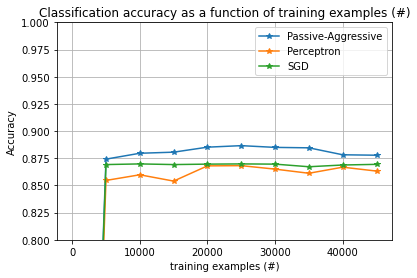

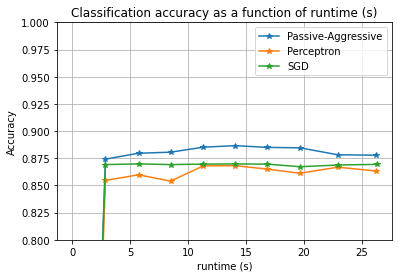

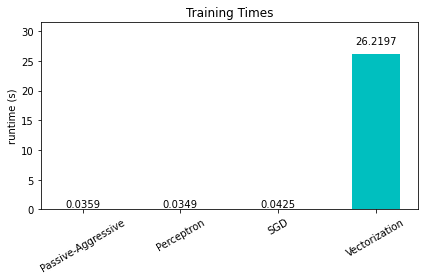

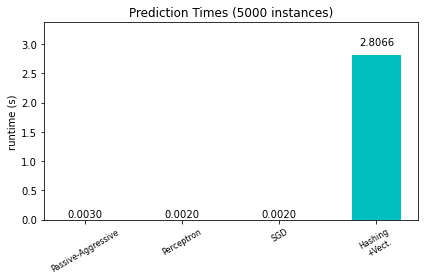

In [224]:
def plot_accuracy(x, y, x_legend):
    """Plot accuracy as a function of x."""
    x = np.array(x)
    y = np.array(y)
    plt.title("Classification accuracy as a function of %s" % x_legend)
    plt.xlabel("%s" % x_legend)
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.plot(x, y,marker="*")

rcParams["legend.fontsize"] = 10
cls_names = list(sorted(cls_stats.keys()))

# Plot accuracy evolution
plt.figure()
for _, stats in sorted(cls_stats.items()):
    # Plot accuracy evolution with #examples
    accuracy, n_examples = zip(*stats["accuracy_history"])
    plot_accuracy(n_examples, accuracy, "training examples (#)")
    ax = plt.gca()
    ax.set_ylim((0.8, 1))
plt.legend(cls_names, loc="best")

plt.figure()
for _, stats in sorted(cls_stats.items()):
    # Plot accuracy evolution with runtime
    accuracy, runtime = zip(*stats["runtime_history"])
    plot_accuracy(runtime, accuracy, "runtime (s)")
    ax = plt.gca()
    ax.set_ylim((0.8, 1))
plt.legend(cls_names, loc="best")

# Plot fitting times
plt.figure()
fig = plt.gcf()
cls_runtime = [stats["total_fit_time"] for cls_name, stats in sorted(cls_stats.items())]

cls_runtime.append(total_vect_time)
cls_names.append("Vectorization")
bar_colors = ["b", "g", "r", "c", "m", "y"]

ax = plt.subplot(111)
rectangles = plt.bar(range(len(cls_names)), cls_runtime, width=0.5, color=bar_colors)

ax.set_xticks(np.linspace(0, len(cls_names) - 1, len(cls_names)))
ax.set_xticklabels(cls_names, fontsize=10)
ymax = max(cls_runtime) * 1.2
ax.set_ylim((0, ymax))
ax.set_ylabel("runtime (s)")
ax.set_title("Training Times")


def autolabel(rectangles):
    """attach some text vi autolabel on rectangles."""
    for rect in rectangles:
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2.0,
            1.05 * height,
            "%.4f" % height,
            ha="center",
            va="bottom",
        )
        plt.setp(plt.xticks()[1], rotation=30)


autolabel(rectangles)
plt.tight_layout()
plt.show()

# Plot prediction times
plt.figure()
cls_runtime = []
cls_names = list(sorted(cls_stats.keys()))
for cls_name, stats in sorted(cls_stats.items()):
    cls_runtime.append(stats["prediction_time"])
cls_runtime.append(vectorizing_time)
cls_names.append("Hashing\n+Vect.")

ax = plt.subplot(111)
rectangles = plt.bar(range(len(cls_names)), cls_runtime, width=0.5, color=bar_colors)

ax.set_xticks(np.linspace(0, len(cls_names) - 1, len(cls_names)))
ax.set_xticklabels(cls_names, fontsize=8)
plt.setp(plt.xticks()[1], rotation=30)
ymax = max(cls_runtime) * 1.2
ax.set_ylim((0, ymax))
ax.set_ylabel("runtime (s)")
ax.set_title("Prediction Times (%d instances)" % n_test_documents)
autolabel(rectangles)
plt.tight_layout()
plt.show()

Conclusion: Out-of-core learning gives accuracy of about 0.87, slightly less than GridsearchCV for Logistic Regression but superior in terms of run time